In [1]:
from astropy.io import fits
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ckdtree as kdtree 
import itertools
import matplotlib as mpl
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
#print mpl.rcParams.keys()
import pdb
%matplotlib inline

In [2]:
#read in TGAS data for and matched sample for magnitudes 
tgas = fits.getdata("stacked_tgas.fits", 1)
tgasRave = fits.getdata('tgas-rave.fits', 1)
tgasApass = fits.getdata('tgas-matched-apass-dr9.fits')
tgasWise = fits.getdata('tgas-matched-wise.fits')
tgas2mass = fits.getdata('tgas-matched-2mass.fits')

In [3]:
print tgas2mass.dtype.names

('ra', 'dec', 'key', 'err_major', 'err_minor', 'err_angle', 'designation', 'northern_hemi', 'galaxy_contam', 'prox', 'prox_angle', 'prox_key', 'date_year', 'date_month', 'date_day', 'jdate', 'scan', 'minor_planet', 'phi_opt', 'glon', 'glat', 'x_scan', 'n_opt_matches', 'dist_opt', 'b_m_opt', 'vr_m_opt', 'dist_edge_ns', 'dist_edge_ew', 'dist_flag_ns', 'dist_flag_ew', 'dup_src', 'use_src', 'association', 'coadd_key', 'coadd', 'scan_key', 'xsc_key', 'j_mag', 'j_cmsig', 'j_msigcom', 'j_m_stdap', 'j_msig_stdap', 'j_snr', 'j_quality', 'j_read', 'j_blend', 'j_cc', 'j_ndet_m', 'j_ndet_n', 'j_psfchi', 'h_mag', 'h_cmsig', 'h_msigcom', 'h_m_stdap', 'h_msig_stdap', 'h_snr', 'h_quality', 'h_read', 'h_blend', 'h_cc', 'h_ndet_m', 'h_ndet_n', 'h_psfchi', 'k_mag', 'k_cmsig', 'k_msigcom', 'k_m_stdap', 'k_msig_stdap', 'k_snr', 'k_quality', 'k_read', 'k_blend', 'k_cc', 'k_ndet_m', 'k_ndet_n', 'k_psfchi', 'matched', 'matchdist')


In [4]:
nonNans = ~np.isnan(tgasRave['TEFF']) & ~np.isnan(tgasRave['LOGG']) & ~np.isnan(tgasRave['FE_H'])
tgasRave = tgasRave[nonNans]

In [5]:
#read in Adrian's distances from sampling the posterior 
ndist = 200
nfiles = 16
dist = None #np.zeros(len(tgasMatched), ndist)
for j in range(1,nfiles+1):
    with h5py.File("distance-samples-{:02d}.hdf5".format(j)) as f:
        if dist is None:
            dist = f['distance'][:,:ndist]
        else:
            dist = np.concatenate((dist, f['distance'][:,:ndist]))

#calculate the median distance from the posterior and proper error for cuts 
medianDist = np.median(dist, axis=1)
err = np.sqrt(tgas['parallax_error']**2. + 0.3**2.)


In [6]:
#various cuts to select sample 
proj = 'twins'
ndist = ndist
nNeighbors = 2048
magSN = 16.
sigMax = 1.086/magSN
maxDist = 8000. #1000. #pc
fracErrorDistance = 1.

if proj ==  'twins':
    minDist = 0.0 #pc
    parallaxSN = 16.
    galacticLatMin = 5. #degrees
    galacticLatMax = None #degrees
if proj == 'dust':
    minDist = 250. #pc
    parallaxSN = 5.
    galacticLatMin = 0.  #degrees 
    galacticLatMax = 10. #degrees
    
mags = ['bmag', 'gmag', 'vmag', 'rmag', 'imag']
errors = ['e_bmag', 'e_gmag', 'e_vmag', 'e_rmag', 'e_imag']
wavelength = [420., 475., 520., 658., 806.]

In [7]:
#current cut: no magnitudes are NaNs, 0 < errors < sigMax, 
#print np.sum(tgas['parallax']/err > parallaxSN)

noNans = ~np.isnan(tgasApass['bmag']) & ~np.isnan(tgasApass['vmag']) & \
         ~np.isnan(tgasApass['gmag']) & ~np.isnan(tgasApass['rmag']) & \
         ~np.isnan(tgasApass['imag'])

posErrors = (tgasApass['e_bmag'] > 0) & (tgasApass['e_vmag'] > 0) & \
            (tgasApass['e_gmag'] > 0) & (tgasApass['e_rmag'] > 0) & \
            (tgasApass['e_imag'] > 0)

lowPhotError = (tgasApass['e_bmag'] < sigMax) & (tgasApass['e_vmag'] < sigMax) & \
               (tgasApass['e_gmag'] < sigMax) & (tgasApass['e_rmag'] < sigMax) & \
               (tgasApass['e_imag'] < sigMax) 
        
lowPhotError_IR = (tgas2mass['j_cmsig'] < sigMax) & (tgas2mass['h_cmsig'] < sigMax) & \
                  (tgas2mass['k_cmsig'] < sigMax)  & (tgasWise['w1sigmpro'] < sigMax) & \
                  (tgasWise['w2sigmpro'] < sigMax) & (tgasWise['w3sigmpro'] < sigMax) 
            
noDust = (medianDist < maxDist) & (np.abs(tgas['b']) > galacticLatMin)

apassMatch = tgasApass['matched']

wiseMatch = tgasWise['matched']

twoMassMatch = tgas2mass['matched']

goodDistance = tgas['parallax']/err > parallaxSN

hasDust = medianDist >= minDist

raveMatch = np.in1d(tgas['source_id'], tgasRave['source_id'])

if galacticLatMax: inDisk = np.abs(tgas['b'] <= galacticLatMax)

matched = goodDistance & noNans & posErrors & lowPhotError & noDust &\
           apassMatch & raveMatch & twoMassMatch & wiseMatch & lowPhotError_IR 

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in less


In [8]:
print np.sum(tgasWise['w4sigmpro'] < sigMax)

187352


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [9]:
tgasMatched = tgas[matched]
magsMatched = tgasApass[matched]
wiseMatched = tgasWise[matched]
twoMassMatched = tgas2mass[matched]
errMatched = err[matched]
raveInd = np.in1d(tgasRave['source_id'], tgasMatched['source_id'])
raveMatched = tgasRave[raveInd]

In [10]:
#raveNonNan = ~np.isnan(raveMatched['TEFF']) & ~np.isnan(raveMatched['LOGG'])
#raveMatched = raveMatched[raveNonNan]

In [11]:
print 'Number of tgas stars: ', len(tgas)
print 'Number of matched stars: ', np.sum(matched)
print 'Percent matched = ', 100 - (len(tgas) - np.sum(matched))/np.float(len(tgas))*100., '%'
#print np.min(magsMatched['gmag']), np.max(magsMatched['gmag'])

Number of tgas stars:  2057050
Number of matched stars:  1253
Percent matched =  0.0609124717435 %


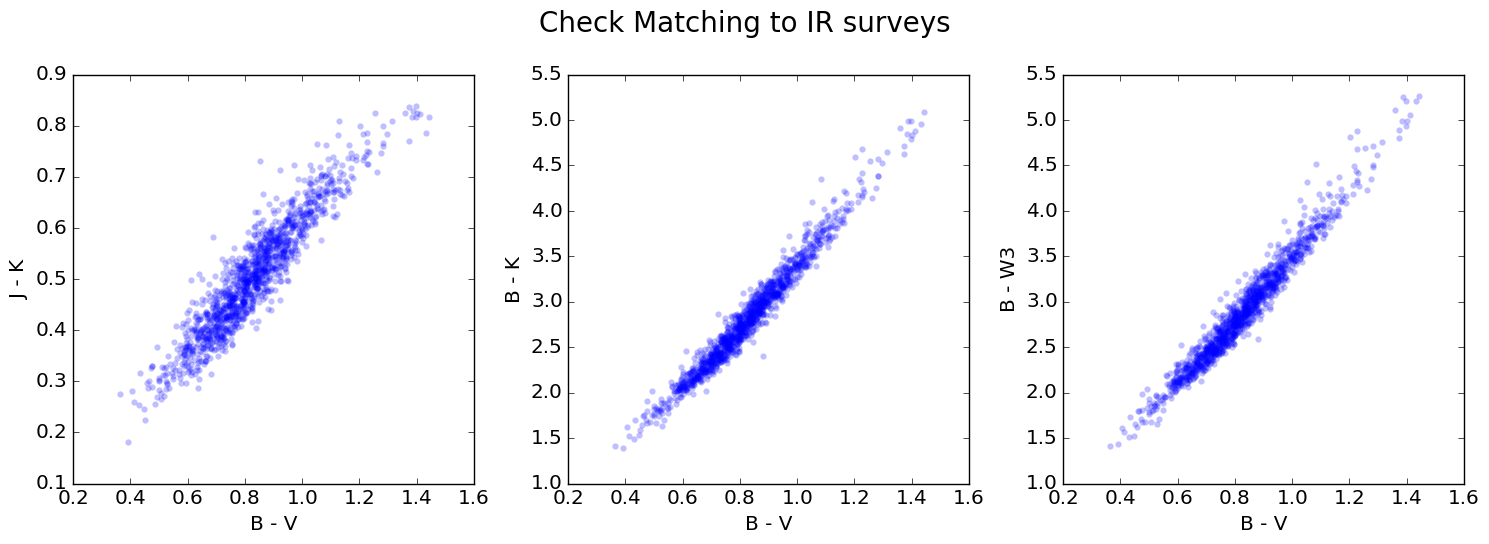

In [48]:
#add 2MASS and WISE (farther infrared)
#make color color plots to check outliers B-V J-K anamolies where stars are getting fucked up in matching 
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Check Matching to IR surveys', fontsize=20, y=1.08)
ax[0].scatter(magsMatched['bmag'] - magsMatched['vmag'], twoMassMatched['j_mag'] - twoMassMatched['k_mag'], alpha=0.25, lw=0)
ax[0].set_xlabel('B - V')
ax[0].set_ylabel('J - K')

ax[1].scatter(magsMatched['bmag'] - magsMatched['vmag'], magsMatched['bmag'] - twoMassMatched['k_mag'], alpha=0.25, lw=0)
ax[1].set_xlabel('B - V')
ax[1].set_ylabel('B - K')

ax[2].scatter(magsMatched['bmag'] - magsMatched['vmag'], magsMatched['bmag'] - wiseMatched['w3mpro'], alpha=0.25, lw=0)
ax[2].set_xlabel('B - V')
ax[2].set_ylabel('B - W3')


plt.tight_layout()
plt.savefig('IRmatchCheck.png')

In [13]:
if nNeighbors > np.sum(matched): nNeighbors = np.sum(matched)

In [14]:
distMatched = dist[matched]
medianDistMatched = np.median(distMatched, axis=1)
muMatched = 5. * np.log10(distMatched / 10.) # 10 pc is mu = 0
meanMuMatched = np.mean(muMatched, axis=1)
varMuMatched = np.mean((muMatched - meanMuMatched[:,None]) ** 2, axis=1)

In [15]:
#Assuming an R_V of 3.1, good assumption for Milky Way so say Schlafly+Finkbeiner
#include dust, narrower correlations, B-K 
#add wrong sign 
#look for precomputed attenuation for bandpasses 
#check that sign is correct
B_RedCoeff = 3.626
V_RedCoeff = 2.742
g_RedCoeff = 3.303
r_RedCoeff = 2.285
i_RedCoeff = 1.698

//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3578: RuntimeWarning: Invalid value encountered in median for 817 results
  RuntimeWarning)
//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3578: RuntimeWarning: Invalid value encountered in median for 25327 results
  RuntimeWarning)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in greater
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in greater


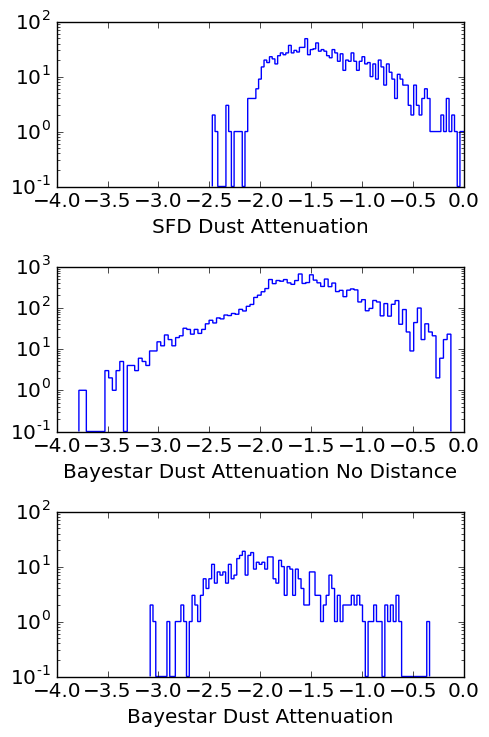

In [16]:
#include dust
from dustmaps.sfd import SFDQuery
from dustmaps.bayestar import BayestarQuery
from astropy.coordinates import SkyCoord
import astropy.units as units
sfd = SFDQuery()
bayes = BayestarQuery(max_samples=2)
c = SkyCoord(
        tgasMatched['l']*units.deg,
        tgasMatched['b']*units.deg,
        distance = medianDistMatched*units.pc,
        frame='galactic')
cNoDist = SkyCoord(
        tgasMatched['l']*units.deg,
        tgasMatched['b']*units.deg,
        frame='galactic')

bayesDust = bayes(c, mode='median')
bayesDustNoDist = bayes(cNoDist, mode='median')

fig, ax = plt.subplots(3, figsize=(5, 7.5))

ax[0].hist(np.log10(sfd(c)), bins=100, log=True, histtype='step')
ax[1].hist(np.log10(bayesDustNoDist[bayesDustNoDist>0]), bins=100, log=True, histtype='step')
ax[2].hist(np.log10(bayesDust[bayesDust >0]), bins=100, log=True, histtype='step')

ax[0].set_xlabel('SFD Dust Attenuation')
ax[1].set_xlabel('Bayestar Dust Attenuation No Distance')
ax[2].set_xlabel('Bayestar Dust Attenuation')
for a in ax: a.set_xlim(-4, 0.0)
plt.tight_layout()

In [17]:
np.sum(np.isnan(bayesDust))

817

11.9611 11.9318 [ 0.30298319  0.28681988  0.03379282 ...,  0.05237664  0.04532991
  0.02636127]


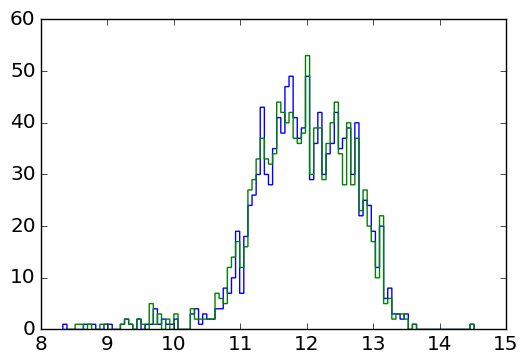

In [18]:
#!!!!! Do something else than setting it equal to 0 !!!!! 
bayesDust[np.isnan(bayesDust)] = 0.0
hist, bins = np.histogram(magsMatched['bmag'], bins=100)
plt.hist(magsMatched['bmag'], bins=bins, histtype='step')
plt.hist(magsMatched['bmag'] - B_RedCoeff*bayesDust, bins=bins, histtype='step')
print np.mean(magsMatched['bmag']), np.mean(magsMatched['bmag'] - B_RedCoeff*bayesDust), B_RedCoeff*bayesDust

In [19]:
#B_RedCoeff*bayesDust
M_V = magsMatched['vmag'] - V_RedCoeff*bayesDust - meanMuMatched
B_V = magsMatched['bmag'] - B_RedCoeff*bayesDust - (magsMatched['vmag'] - V_RedCoeff*bayesDust)
g_r = magsMatched['gmag'] - g_RedCoeff*bayesDust - (magsMatched['rmag'] - r_RedCoeff*bayesDust)
r_i = magsMatched['rmag'] - r_RedCoeff*bayesDust - (magsMatched['imag'] - i_RedCoeff*bayesDust)

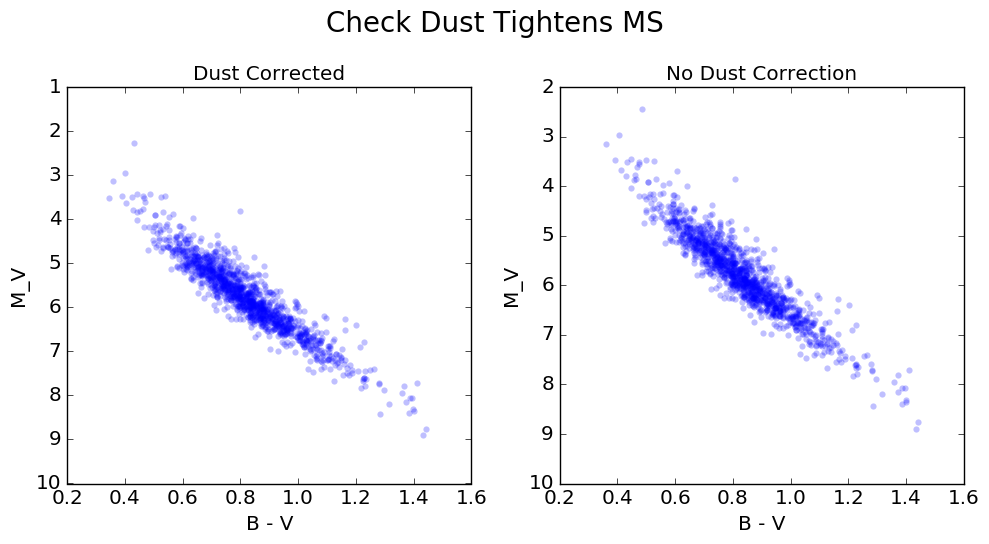

In [47]:
#check dust tightens main sequence 
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Check Dust Tightens MS', fontsize=20, y=1.08)
ax[0].scatter(B_V, M_V, alpha=0.25, lw=0)
ax[0].set_xlabel('B - V')
ax[0].set_ylabel('M_V')
ax[0].set_title('Dust Corrected')
ax[0].invert_yaxis()

ax[1].scatter(magsMatched['bmag'] - magsMatched['vmag'], magsMatched['vmag'] - meanMuMatched, alpha=0.25, lw=0)
ax[1].set_xlabel('B - V')
ax[1].set_ylabel('M_V')
ax[1].set_title('No Dust Correction')
ax[1].invert_yaxis()
plt.tight_layout()
plt.savefig('dustCorrected.png')

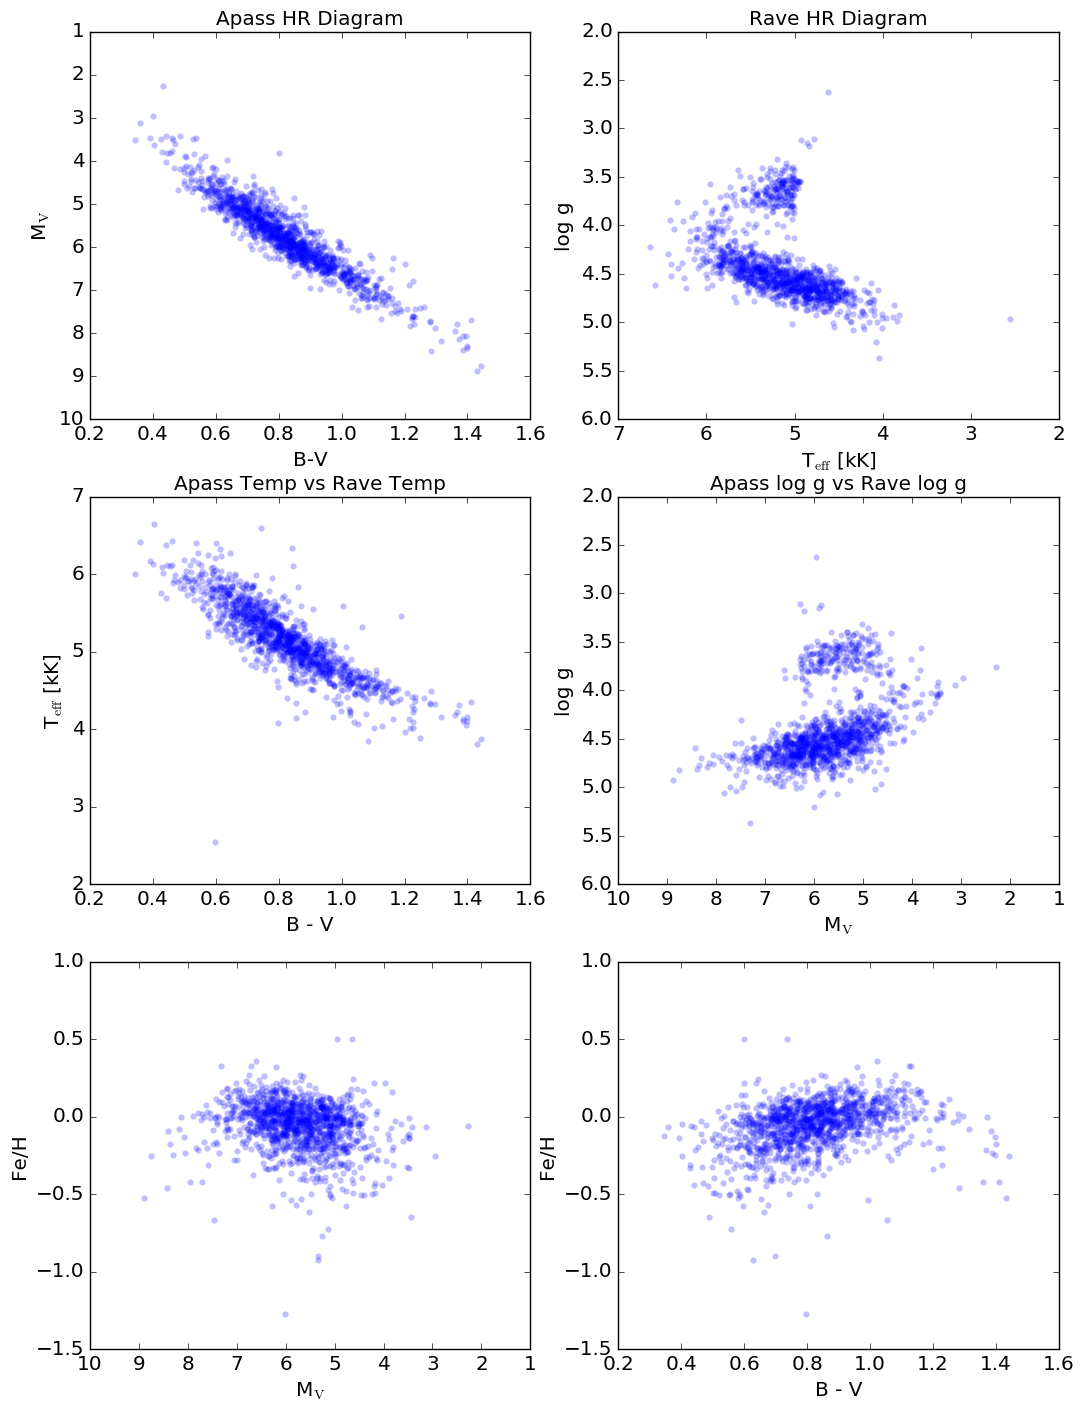

In [21]:
# plot all stars under consideration 
fig, axes = plt.subplots(3,2, figsize=(12.5, 17))
axes = axes.flatten()
axes[0].scatter(B_V,M_V, alpha=0.25, lw=0)
axes[0].invert_yaxis()
axes[0].set_xlabel('B-V')
axes[0].set_ylabel('M$_\mathrm{V}$')
axes[0].set_title('Apass HR Diagram')

axes[1].scatter(raveMatched['TEFF']/1000., raveMatched['LOGG'], alpha=0.25, lw=0)
axes[1].invert_yaxis()
axes[1].invert_xaxis()
axes[1].set_xlabel('T$_\mathrm{eff}$ [kK]')
axes[1].set_ylabel('log g')
axes[1].set_title('Rave HR Diagram')

axes[2].scatter(B_V, raveMatched['TEFF']/1000., alpha=0.25, lw=0)
#axes[2].invert_xaxis()
axes[2].set_ylabel('T$_\mathrm{eff}$ [kK]')
axes[2].set_xlabel('B - V')
axes[2].set_title('Apass Temp vs Rave Temp')

axes[3].scatter(M_V, raveMatched['LOGG'], alpha=0.25, lw=0)
axes[3].set_xlabel('M$_\mathrm{V}$')
axes[3].set_ylabel('log g')
axes[3].invert_yaxis()
axes[3].invert_xaxis()
axes[3].set_title('Apass log g vs Rave log g')

axes[4].scatter(M_V, raveMatched['FE_H'], alpha=0.25, lw=0)
axes[4].invert_xaxis()
axes[4].set_xlabel('M$_\mathrm{V}$')
axes[4].set_ylabel('Fe/H')


axes[5].scatter(B_V, raveMatched['FE_H'], alpha=0.25, lw=0)
#axes[5].invert_xaxis()
axes[5].set_xlabel('B - V')
axes[5].set_ylabel('Fe/H')
plt.savefig('AllStarsMatched.png')

In [22]:
treeColor = kdtree.cKDTree(data=zip(M_V, B_V, g_r, r_i))

In [23]:
treeRave = kdtree.cKDTree(data=zip(M_V, B_V, g_r, r_i, raveMatched['LOGG'], raveMatched['TEFF']))

In [24]:
#some magsMatched[matchedInd, sourceInd] have 0.0 error :/

def distMetric(sourceInd, matchedInd, p=False):
    colorChiSq = 0.0
    colorSigs = 0.0
    colors = [B_V, g_r, r_i]
    color_errors = [['e_bmag', 'e_vmag'], ['e_gmag', 'e_rmag'], ['e_rmag', 'e_imag']]
    for color, error in zip(colors, color_errors):
        #print mag, error, sourceInd, matchedInd
        colorChiSq += (color[sourceInd] - color[matchedInd])**2./\
                      (magsMatched[error[0]][sourceInd]**2. + magsMatched[error[1]][sourceInd]**2. + \
                       magsMatched[error[0]][matchedInd]**2.+ magsMatched[error[1]][matchedInd]**2.)
        colorSigs += np.log(magsMatched[error[0]][matchedInd]**2. + magsMatched[error[1]][matchedInd]**2. + \
                           magsMatched[error[0]][sourceInd]**2. + magsMatched[error[1]][sourceInd]**2.)
    absMagChiSq = (M_V[sourceInd] - M_V[matchedInd])**2./\
                  (magsMatched['e_vmag'][sourceInd]**2. + magsMatched['e_vmag'][matchedInd]**2. +\
                   varMuMatched[sourceInd] + varMuMatched[matchedInd])
    absMagSigs = np.log(magsMatched['e_vmag'][sourceInd]**2. + magsMatched['e_vmag'][matchedInd]**2. +\
                   varMuMatched[sourceInd] + varMuMatched[matchedInd])
    totChiSq = colorChiSq + absMagChiSq + colorSigs + absMagSigs
    if p:
        print 'the total chi2: ',totChiSq[0:5]
        print 'the color chi2: ',colorChiSq[0:5]
        print 'the color sigs: ', colorSigs[0:5]
        print 'the absmag chi2:',absMagChiSq[0:5]
        print 'the absmag sigs:',absMagSigs[0:5]
    #if np.sum(np.isinf(totChiSq)): pdb.set_trace()
    return totChiSq

In [25]:
def calcChisq(sourceIndex, pts, tree, nNeighbors=200, printChi=False):
    treeDistNum, treeIndex = tree.query(pts, k=nNeighbors)
    treeIndNum = treeIndex[1:]
    chisq = distMetric(sourceIndex, treeIndex, p=printChi)
    return chisq, treeIndex

In [26]:
#check ChiSq are what you think they are, correct length, why inf?
sources = []
matches = []
nstars = np.sum(matched)
chisqThreshold = 100
chisqApass = []
nstars = 10
for star in np.arange(nstars):
    pts = [M_V[star], B_V[star], g_r[star], r_i[star]]
    chisq, treeIndex = calcChisq(star, pts, treeColor, nNeighbors=nNeighbors, printChi=False)
    sort = np.argsort(treeIndex)
    chisq = chisq[sort]
    treeIndex = treeIndex[sort]
    chisqApass.append(chisq[chisq < chisqThreshold])
    treeIndex = treeIndex[chisq < chisqThreshold]
    sources.append(star)
    matches.append(treeIndex)

In [27]:
def distRave(sourceInd, matchesInd):
    chisq = (raveMatched['TEFF'][sourceInd] - raveMatched['TEFF'][matchesInd])**2./(raveMatched['E_TEFF'][sourceInd]**2. + raveMatched['E_TEFF'][matchesInd]**2.) + \
            (raveMatched['LOGG'][sourceInd] - raveMatched['LOGG'][matchesInd])**2./(raveMatched['E_LOGG'][sourceInd]**2. + raveMatched['E_LOGG'][matchesInd]**2.) + \
            (raveMatched['FE_H'][sourceInd] - raveMatched['FE_H'][matchesInd])**2./(raveMatched['E_FE_H'][sourceInd]**2. + raveMatched['E_FE_H'][matchesInd]**2.) + \
            np.log(raveMatched['E_TEFF'][sourceInd]**2. + raveMatched['E_TEFF'][matchesInd]**2.) + \
            np.log(raveMatched['E_LOGG'][sourceInd]**2. + raveMatched['E_LOGG'][matchesInd]**2.) + \
            np.log(raveMatched['E_FE_H'][sourceInd]**2. + raveMatched['E_FE_H'][matchesInd]**2.)
    return np.sqrt(chisq) 
            

In [28]:
raveSource = []
raveMatch = []
chisqRave = []
for s, m in zip(sources, matches):
    raveStar = np.where(np.in1d(raveMatched['source_id'], tgasMatched[s]['source_id']))[0]
    raveTwins = np.where(np.in1d(raveMatched['source_id'], tgasMatched[m]['source_id']))[0]
    if np.sum(raveMatched['source_id'][raveTwins] - tgasMatched[m]['source_id']) != 0: print 'Rave not sorted like Apass'
    raveSource.append(raveStar)
    raveMatch.append(raveTwins)
    chisq = distRave(raveStar, raveTwins)
    chisqRave.append(chisq)
#print indices

In [29]:
np.sum(raveMatched['source_id'][raveTwins] - tgasMatched[m]['source_id'][np.argsort(tgasMatched[m]['source_id'])])
argsort = np.argsort(tgasMatched[m]['source_id'])
raveInd = np.where(np.in1d(raveMatched['source_id'], tgasMatched[m]['source_id']))
print np.sum(tgasMatched[m]['source_id'][argsort] - raveMatched[raveInd]['source_id'])#[argsort]

0


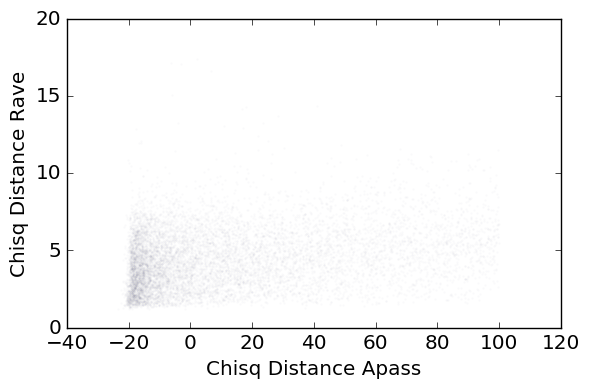

In [30]:
fig, ax = plt.subplots()
for chiA, chiR in zip(chisqApass, chisqRave):
    ax.scatter(chiA, chiR, alpha=0.01, s=1)
#ax.set_xlim(0, 10)
#ax.set_ylim(0, 15)
ax.set_xlabel('Chisq Distance Apass')
ax.set_ylabel('Chisq Distance Rave')
plt.tight_layout()
plt.savefig('chisqApassRaveUncorrelated.png')
plt.show()

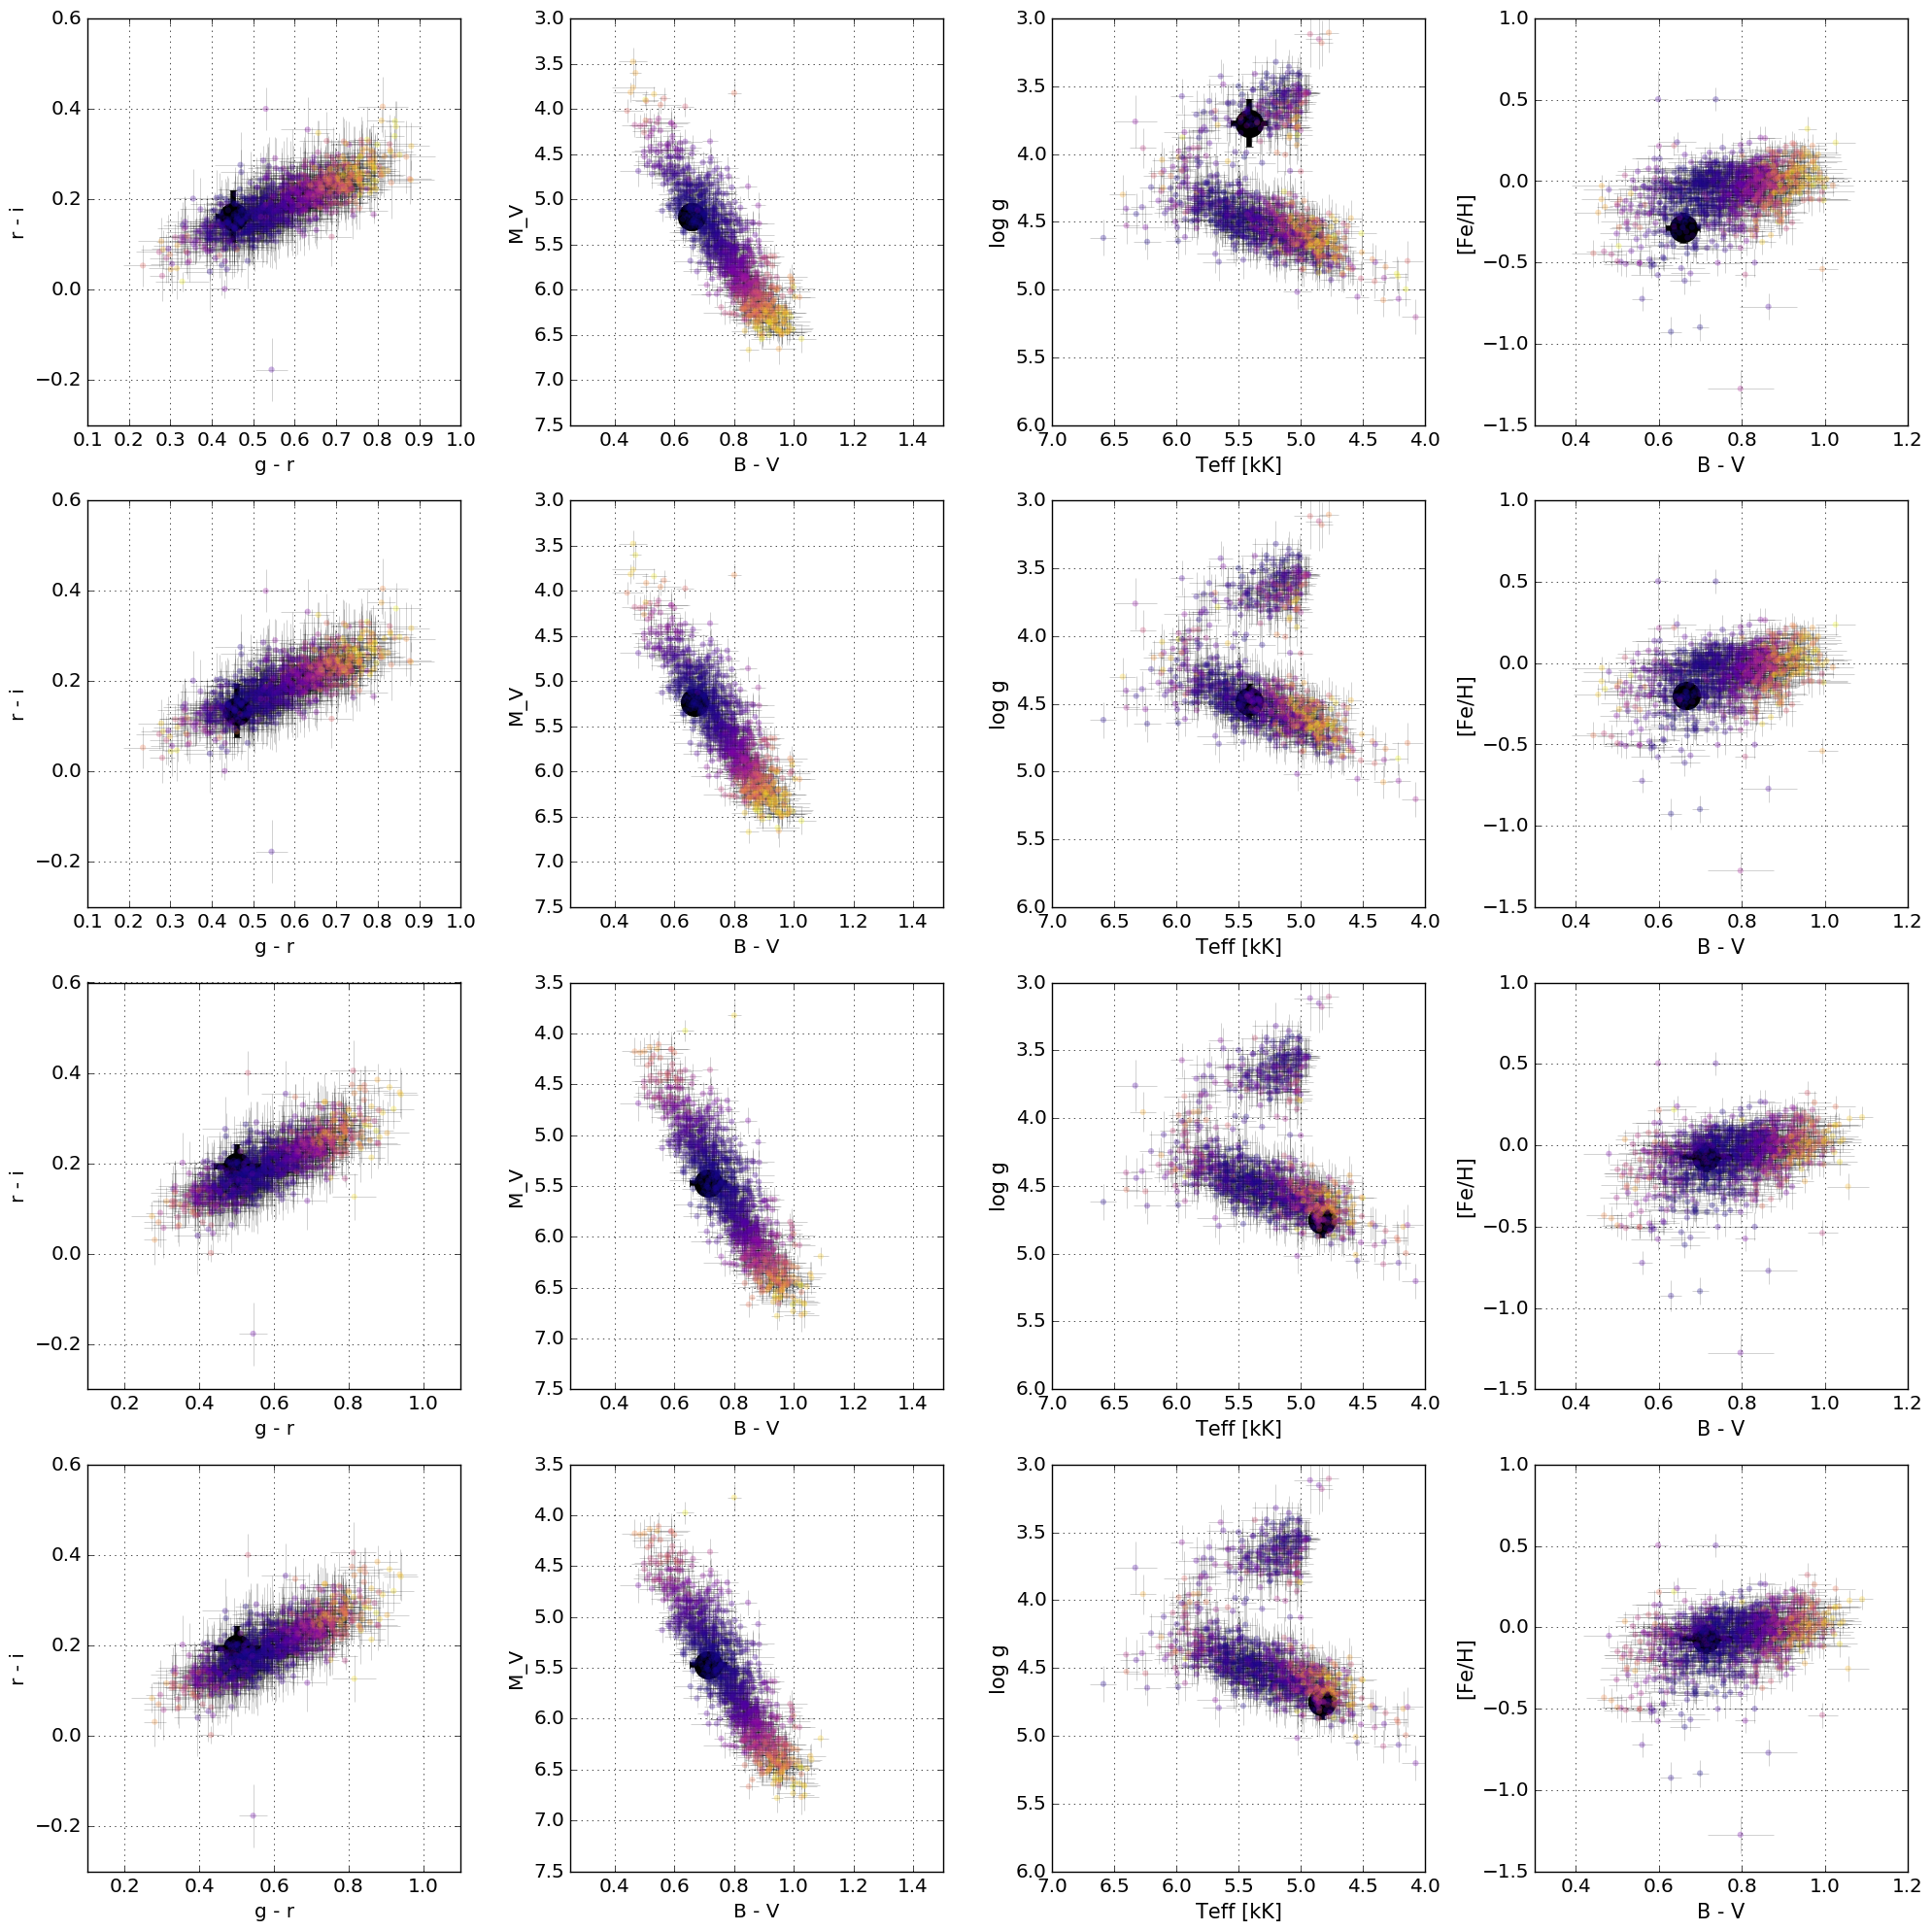

In [31]:
nplot = 4
fig, ax = plt.subplots(nplot, 4, figsize=(20, nplot*5))
axes = itertools.cycle(ax.ravel())
alpha_points = 0.3
alpha_bars = 0.25

b_v_lim = [0.25, 1.5]
g_r_lim = None #[0, 1.5]

r_i_lim = None #[-0.25, 0.75]
M_v_lim = None #[10, 2]

teff_lim = [7, 4] #kK
log_g_lim = [6, 3] 

randarray = np.random.randint(0, high=len(sources), size=nplot)
randarray = randarray[np.argsort(M_V[sources][randarray])]
for j in randarray:
    ax = axes.next()
    twins = matches[j]
    star = sources[j]
    raveTwins = raveMatch[j]
    raveStar = raveSource[j]
    chiApass = chisqApass[j]

    #plot B-V vs g-r for the source and twins 
    ax.scatter(g_r[twins], r_i[twins], c=chiApass + np.min(chiApass), cmap='plasma', norm=mpl.colors.Normalize(), lw=0, zorder=100, alpha=alpha_points)
    ax.errorbar(g_r[twins], r_i[twins], 
                xerr = np.sqrt(magsMatched['e_gmag'][twins]**2. + magsMatched['e_rmag'][twins]**2.), 
                yerr = np.sqrt(magsMatched['e_rmag'][twins]**2. + magsMatched['e_imag'][twins]**2.), 
                fmt="none", ecolor='black', zorder=0, lw=0.5, mew=0, alpha=alpha_bars)
    ax.errorbar(g_r[star], r_i[star], 
                xerr = np.sqrt(magsMatched['e_bmag'][star]**2. + magsMatched['e_vmag'][star]**2.), 
                yerr = np.sqrt(magsMatched['e_gmag'][star]**2. + magsMatched['e_rmag'][star]**2.), fmt='o', color='black',lw=4)

    ax.scatter(g_r[star], r_i[star], s=400, c='black')
    ax.set_xlabel('g - r')
    ax.set_ylabel('r - i')
    ax.set_xlim(g_r_lim)
    ax.set_ylim(r_i_lim)
    ax.grid()

    #plot r-i and M_v for the source and twins
    ax = axes.next()
    ax.scatter(B_V[twins], M_V[twins], c=chiApass + np.min(chiApass), cmap='plasma', norm=mpl.colors.Normalize(), lw=0, zorder=100, alpha=alpha_points)
    ax.errorbar(B_V[twins], M_V[twins], 
                xerr = np.sqrt(magsMatched['e_bmag'][twins]**2. + magsMatched['e_vmag'][twins]**2.), 
                yerr = np.sqrt(magsMatched['e_vmag'][twins]**2. + varMuMatched[twins]),
                                  fmt="none", ecolor='black', zorder=0, lw=0.5, mew=0, alpha=alpha_bars)
    ax.errorbar(B_V[star], M_V[star], 
                xerr = np.sqrt(magsMatched['e_bmag'][star]**2. + magsMatched['e_vmag'][star]**2.), 
                yerr = np.sqrt(magsMatched['e_vmag'][star]**2. + varMuMatched[star]), 
                fmt='o', color='black', lw=4)
    ax.scatter(B_V[star], M_V[star], s=400, c='black')
    ax.set_xlabel('B - V')
    ax.set_ylabel('M_V')
    ax.invert_yaxis()
    ax.set_xlim(b_v_lim)
    ax.set_ylim(M_v_lim)
    ax.grid()
    
    #plot Teff vs log g for the source and twins
    raveTeff = raveMatched['TEFF'][raveTwins]
    raveLogG = raveMatched['LOGG'][raveTwins]
    #chiSqRavePos = np.array(chisqRave[j])
    #chiSqRavePos[np.isnan(chiSqRavePos)] = 1e2
    #posChisqRave = np.log10(chiSqRavePos)

    ax = axes.next()
    ax.scatter(raveTeff/1000., raveLogG, c=chiApass + np.min(chiApass), cmap='plasma', norm=mpl.colors.Normalize(), lw=0, zorder=100, alpha=alpha_points)
    ax.errorbar(raveTeff/1000., raveLogG, xerr=raveMatched['E_TEFF'][raveTwins]/1000., yerr=raveMatched['E_LOGG'][raveTwins],
               fmt='none', ecolor='black', zorder=0, lw=0.5, mew=0, alpha=alpha_bars)
    ax.scatter(raveMatched['TEFF'][raveStar]/1000., raveMatched['LOGG'][raveStar], s=400, c='black')
    ax.errorbar(raveMatched['TEFF'][raveStar]/1000., raveMatched['LOGG'][raveStar], 
                xerr=raveMatched['E_TEFF'][raveStar]/1000., yerr=raveMatched['E_LOGG'][raveStar],
               fmt='o', color='black', lw=4)
    ax.set_ylabel('log g', fontsize=15)
    ax.set_xlabel('Teff [kK]', fontsize=15)
    ax.set_xlim(teff_lim)
    ax.set_ylim(log_g_lim)
    ax.grid()
    
    ax = axes.next()
    ax.errorbar(B_V[twins], raveMatched['FE_H'][raveTwins], yerr=raveMatched['E_FE_H'][raveTwins], 
              xerr = np.sqrt(magsMatched['e_bmag'][twins]**2. + magsMatched['e_vmag'][twins]**2.),
              fmt='none', ecolor='black', zorder=0, lw=0.5, mew=0, alpha=alpha_bars)
    ax.scatter(B_V[twins], raveMatched['FE_H'][raveTwins], c=chiApass + np.min(chiApass), cmap='plasma', norm=mpl.colors.Normalize(), lw=0, zorder=100, alpha=alpha_points)
    ax.scatter(B_V[star], raveMatched['FE_H'][raveStar], s=400, c='black')
    ax.errorbar(B_V[star], raveMatched['FE_H'][raveStar], yerr=raveMatched['E_FE_H'][raveStar], 
              xerr = np.sqrt(magsMatched['e_bmag'][star]**2. + magsMatched['e_vmag'][star]**2.), fmt='o', color='black', lw=4)
    ax.set_xlabel('B - V', fontsize=15)
    ax.set_ylabel('[Fe/H]', fontsize=15)
    ax.grid()
    
plt.tight_layout()
plt.savefig('TgasApassRave_chisq.png')

In [32]:
#get K nearest neighbors k to star j in a photometry + gaia sense, for each jk pair we have X2jk
#each of the k neighbors has label vector l_k=[Teff_k, logg_k, Fe/H_k]
#posterior pdf for the rave laels for star j are: P(l_j|photometry) ~ sum_k(exp(-X2jk/2)*l_k) ?? k

In [33]:
def gaussian(mean, sigma, array):
    return 1./np.sqrt(2.*np.pi*sigma**2.)*\
                    np.exp(-(array - mean)**2./(2.*sigma**2.))

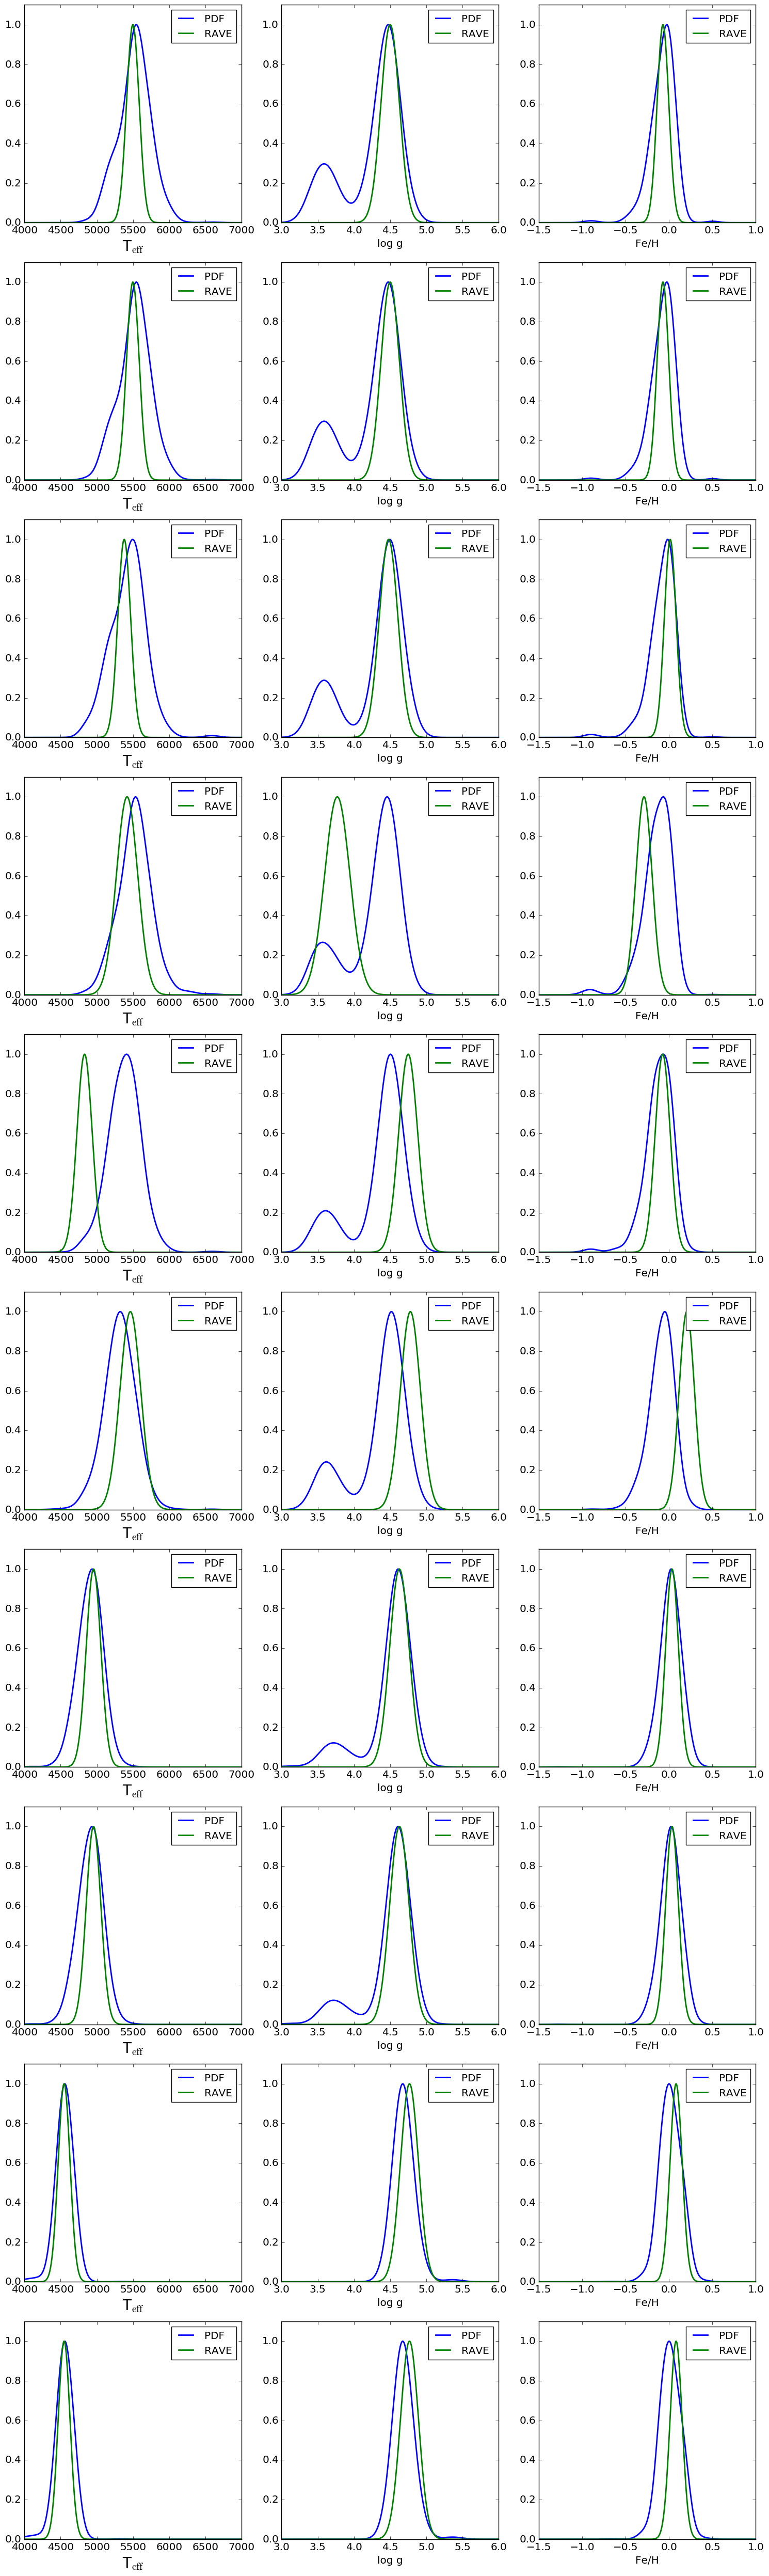

In [46]:
#plot observed vs predicted 

nplot=10
s = 10
alpha=0.1
lw=0
ylim = (0.1, 1e5)

fig, axes = plt.subplots(nplot, 3, figsize=(15, nplot*5))
axes = itertools.cycle(axes.ravel())
randarray = np.random.randint(0, high=len(sources), size=nplot)
randarray = randarray[np.argsort(M_V[sources][randarray])]

npoints = 1000
teff_array = np.linspace(4000, 7000, npoints)
logg_array = np.linspace(3, 6, npoints)
feh_array  = np.linspace(-1.5, 1, npoints)


for j in randarray:

    teff_prob = np.zeros(npoints)
    logg_prob = np.zeros(npoints)
    feh_prob = np.zeros(npoints)
    
    twins = matches[j]
    star = sources[j]
    raveTwins = raveMatch[j]
    raveStar = raveSource[j]
    chiApass = chisqApass[j]
    
    temp = raveMatched['TEFF'][raveTwins]
    temp_err = raveMatched['E_TEFF'][raveTwins]
    
    teff_prob_test = np.exp(-chiApass/2.)/np.sqrt(2.*np.pi*temp_err**2.)*\
                    np.exp(-(teff_array[:,None] - temp)**2./(2.*temp_err**2.))

    logg = raveMatched['LOGG'][raveTwins]
    logg_err = raveMatched['E_LOGG'][raveTwins]

    logg_prob_test = np.exp(-chiApass/2.)/np.sqrt(2.*np.pi*logg_err**2.)*\
                    np.exp(-(logg_array[:,None] - logg)**2./(2.*logg_err**2.))

    feh = raveMatched['FE_H'][raveTwins]
    feh_err = raveMatched['E_FE_H'][raveTwins]

    feh_prob_test = np.exp(-chiApass/2.)/np.sqrt(2.*np.pi*feh_err**2.)*\
                    np.exp(-(feh_array[:,None] - feh)**2./(2.*feh_err**2.))

    
    ax = axes.next()
    ax.plot(teff_array, np.sum(teff_prob_test, axis=1)/np.max(np.sum(teff_prob_test, axis=1)), lw=2, label='PDF')
    #for i in range(len(raveTwins)):ax.plot(teff_array, teff_prob_test[:,i], lw=0.1, color='black')
    star_gauss = gaussian(raveMatched['TEFF'][raveStar], raveMatched['E_TEFF'][raveStar], teff_array)
    ax.plot(teff_array, star_gauss/np.max(star_gauss), lw=2, label='RAVE')
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('T$_\mathrm{eff}$', fontsize=20)
    ax.legend()
    
    ax = axes.next()
    ax.plot(logg_array, np.sum(logg_prob_test, axis=1)/np.max(np.sum(logg_prob_test, axis=1)), lw=2, label='PDF')
    star_gauss = gaussian(raveMatched['LOGG'][raveStar], raveMatched['E_LOGG'][raveStar], logg_array)
    ax.plot(logg_array, star_gauss/np.max(star_gauss), lw=2, label='RAVE')
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('log g')
    ax.legend()
    
    ax = axes.next()
    ax.plot(feh_array, np.sum(feh_prob_test, axis=1)/np.max(np.sum(feh_prob_test, axis=1)), lw=2, label='PDF')
    star_gauss = gaussian(raveMatched['FE_H'][raveStar], raveMatched['E_FE_H'][raveStar], feh_array)
    ax.plot(feh_array, star_gauss/np.max(star_gauss), lw=2, label='RAVE')
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('Fe/H')
    ax.legend()   
    #for i in range(len(raveTwins)):ax.plot(feh_array, feh_prob_test[:,i], lw=0.1, color='black')

    #ax = axes.next()
    #ax.scatter(raveMatched['LOGG'][raveTwins], np.exp(-chiApass/2.),lw=lw,alpha=alpha,s=s)
    #ax.set_yscale('log')
    #ax.set_ylim(ylim)
    #ax = axes.next()
    #ax.scatter(raveMatched['FE_H'][raveTwins], np.exp(-chiApass/2.),lw=lw,alpha=alpha,s=s)
    #ax.set_yscale('log')
    #ax.set_ylim(ylim)

plt.tight_layout()
plt.savefig('PDFvsRAVE.png')

In [ ]:
feh_prob_test[:,3]

In [ ]:
plt.plot(teff_array, np.sum(teff_prob_test, axis=1))
#plt.yscale('log')

In [ ]:
for i in range(1000):plt.plot(teff_array, teff_prob_test[:,i], lw=0.25, color='black')

In [ ]:
print np.exp(-chiApass/2.)/np.sqrt(2.*np.pi*raveMatched['E_TEFF'][raveTwins]**2.)

In [ ]:
print np.exp((teff_array - raveMatched['TEFF'][raveTwins][0])**2./\
                           (2.*raveMatched['E_TEFF'][raveTwins][0]**2.))

In [ ]:
raveMatched['E_TEFF'][raveTwins][0]

In [ ]:
(teff_array - raveMatched['TEFF'][raveTwins][0])**2./(2.*raveMatched['E_TEFF'][raveTwins][0]**2.)